In [2]:
import os
import re
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Paths ----------
DATA_DIR = ".\\data\\"
INPUT_FILENAME = "data-1760978361180.csv"  # change if your filename differs
INPUT_PATH = os.path.join(DATA_DIR, INPUT_FILENAME)

OUT_DIR = os.path.join(DATA_DIR, "analysis_out")
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Load ----------
df = pd.read_csv(INPUT_PATH)

mapping = {"X": "Llama", "Y": "GPT", "Z": "human"}

def map_dmp_name(name):
    if pd.isna(name):
        return name
    s = str(name).strip()
    m = re.fullmatch(r"([XYZ])_(\d+)", s, flags=re.IGNORECASE)
    if m:
        prefix, idx = m.group(1).upper(), m.group(2)
        return f"{mapping[prefix]}_{idx}"
    return s

df["dmpName"] = df["dmpName"].apply(map_dmp_name)
df

,id,participantId,dmpName,evaluations,overallAuthorshipGuess,overallSatisfaction
0,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,"[{""elementTitle"": ""Element 1: Data Type"", ""sel...",Human,4
1,cmfb72lh6000v7101jnbh5lvt,1028,Llama_9,"[{""elementTitle"": ""Element 1: Data Type"", ""sel...",LLM,4
2,cmf5tpuwh000e71013wgcr9tv,1010,Llama_3,"[{""elementTitle"": ""Element 1: Data Type"", ""sel...",Human,2
3,cmf5uiayf000g71018h284wad,1010,human_10,"[{""elementTitle"": ""Element 1: Data Type"", ""sel...",LLM,2
4,cmf5xk8j9000i7101r8lluz8x,1014,Llama_7,"[{""elementTitle"": ""Element 1: Data Type"", ""sel...",LLM,2
...,...,...,...,...,...,...
58,cmgbacxmo00037101e4i175oz,1012,human_7,"[{""elementTitle"": ""Element 1: Data Type"", ""sel...",Human,2
59,cmgf2bbon00057101uiqy4p1v,1015,Llama_8,"[{""elementTitle"": ""Element 1: Data Type"", ""sel...",LLM,2
60,cmgi15cfp00097101gchesweb,1021,Llama_2,"[{""elementTitle"": ""Element 1: Data Type"", ""sel...",LLM,2
61,cmgi1lvac000a7101eg06dnh4,1021,GPT_10,"[{""elementTitle"": ""Element 1: Data Type"", ""sel...",Human,5


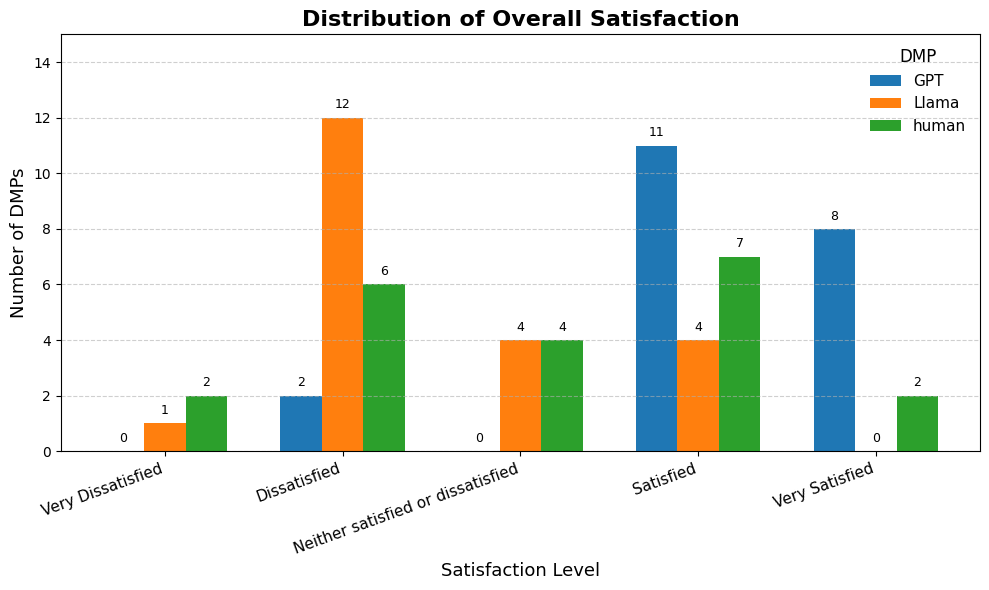

💾 Saved grouped chart to: ./plots\overall_satisfaction_by_group.png


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Output directory (same as before) ---
OUT_DIR = "./plots"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Preprocess ----------
df["Group"] = df["dmpName"].str.extract(r"^(Llama|GPT|human)", expand=False)

# ---------- Build counts table ----------
bins = [1, 2, 3, 4, 5]
counts_tbl = (
    df.groupby(["Group", "overallSatisfaction"])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=bins, fill_value=0)
)

desired_order = ["GPT", "Llama", "human"]
counts_tbl = counts_tbl.reindex(desired_order)

# ---------- Grouped bar chart ----------
x = np.arange(len(bins))  # positions for scores 1..5
groups = counts_tbl.index.tolist()
n_groups = len(groups)
bar_width = 0.7 / n_groups  # narrower bars

# Colorblind-friendly palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green

fig, ax = plt.subplots(figsize=(10, 6))

bars_by_group = {}
for i, (grp, color) in enumerate(zip(groups, colors)):
    counts = counts_tbl.loc[grp].values
    offsets = x - 0.35 + i * bar_width + bar_width / 2
    bars = ax.bar(offsets, counts, width=bar_width, label=grp, color=color)
    bars_by_group[grp] = (bars, counts)

# Axes/labels
ax.set_title("Distribution of Overall Satisfaction", fontsize=16, weight="bold")
ax.set_xlabel("Satisfaction Level", fontsize=13)
ax.set_ylabel("Number of DMPs", fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels([
    "Very Dissatisfied",
    "Dissatisfied",
    "Neither satisfied or dissatisfied",
    "Satisfied",
    "Very Satisfied"
], rotation=20, ha="right", fontsize=11)

# Add count labels (NO percentages)
ymax = counts_tbl.values.max() * 1.25 if counts_tbl.values.size else 1
ax.set_ylim(0, ymax)

for grp, (bars, counts) in bars_by_group.items():
    for bar, c in zip(bars, counts):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + (ymax * 0.015),
            f"{int(c)}",  # only count
            ha="center", va="bottom", fontsize=9
        )

ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.legend(title="DMP", fontsize=11, title_fontsize=12, frameon=False)
fig.tight_layout()

# Save
save_path = os.path.join(OUT_DIR, "overall_satisfaction_by_group.png")
fig.savefig(save_path, dpi=300)
plt.show()
plt.close(fig)

print("💾 Saved grouped chart to:", save_path)


In [5]:

df["Group"] = df["dmpName"].str.extract(r"^(Llama|GPT|human)", expand=False)

# Ensure overallSatisfaction is numeric and within 1..5
df["overallSatisfaction"] = pd.to_numeric(df["overallSatisfaction"], errors="coerce")
df = df[df["overallSatisfaction"].between(1, 5, inclusive="both")]

# ---------- Build counts table: rows = Group, cols = 1..5 ----------
bins = [1, 2, 3, 4, 5]
counts_tbl = (
    df.groupby(["Group", "overallSatisfaction"])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=bins, fill_value=0)
      .sort_index()
)

# Optional: fix group order
desired_order = ["GPT", "Llama", "human"]
counts_tbl = counts_tbl.reindex(desired_order)

# ---------- Percent table (row-normalized) ----------
row_totals = counts_tbl.sum(axis=1).replace(0, np.nan)
perc_tbl = counts_tbl.div(row_totals, axis=0) * 100
perc_tbl = perc_tbl.fillna(0).round(1)

# ---------- Summary stats by group ----------
summary_tbl = (
    df.groupby("Group")["overallSatisfaction"]
      .agg(N="count", mean="mean", std="std", median="median", min="min", max="max")
      .reindex(desired_order)
      .round({"mean": 3, "std": 3, "median": 3})
)

# ---------- Combined wide table (counts + percents) ----------
# MultiIndex columns like ('count', 1), ('percent', 1), ...
counts_named = counts_tbl.copy()
counts_named.columns = pd.MultiIndex.from_product([["count"], counts_named.columns])

perc_named = perc_tbl.copy()
perc_named.columns = pd.MultiIndex.from_product([["percent"], perc_named.columns])

wide_tbl = pd.concat([counts_named, perc_named], axis=1)
# Optional: sort top-level columns so 'count' columns appear before 'percent'
wide_tbl = wide_tbl.reindex(columns=["count", "percent"], level=0)

# ---------- Save CSVs ----------
counts_csv = os.path.join(OUT_DIR, "satisfaction_counts_by_group.csv")
perc_csv   = os.path.join(OUT_DIR, "satisfaction_percent_by_group.csv")
summ_csv   = os.path.join(OUT_DIR, "satisfaction_summary_by_group.csv")
wide_csv   = os.path.join(OUT_DIR, "satisfaction_counts+percents_wide.csv")

counts_tbl.to_csv(counts_csv, index=True)
perc_tbl.to_csv(perc_csv, index=True)
summary_tbl.to_csv(summ_csv, index=True)
# For multiindex columns, write a nice header
wide_tbl.to_csv(wide_csv, index=True)

print("Saved:")
print(" -", counts_csv)
print(" -", perc_csv)
print(" -", summ_csv)
print(" -", wide_csv)

# ---------- Quick sanity printouts ----------
print("\n=== COUNTS (by Group x Score) ===")
print(counts_tbl)

print("\n=== PERCENT (by Group x Score) ===")
print(perc_tbl)

print("\n=== SUMMARY (N, mean, std, median, min, max) ===")
print(summary_tbl)

Saved:
 - ./plots\satisfaction_counts_by_group.csv
 - ./plots\satisfaction_percent_by_group.csv
 - ./plots\satisfaction_summary_by_group.csv
 - ./plots\satisfaction_counts+percents_wide.csv

=== COUNTS (by Group x Score) ===
overallSatisfaction  1   2  3   4  5
Group                               
GPT                  0   2  0  11  8
Llama                1  12  4   4  0
human                2   6  4   7  2

=== PERCENT (by Group x Score) ===
overallSatisfaction    1     2     3     4     5
Group                                           
GPT                  0.0   9.5   0.0  52.4  38.1
Llama                4.8  57.1  19.0  19.0   0.0
human                9.5  28.6  19.0  33.3   9.5

=== SUMMARY (N, mean, std, median, min, max) ===
        N   mean    std  median  min  max
Group                                    
GPT    21  4.190  0.873     4.0    2    5
Llama  21  2.524  0.873     2.0    1    4
human  21  3.048  1.203     3.0    1    5


In [6]:
# ===== Step: Authorship guess correctness (Human vs LLM) =====
# Rules:
# - If dmpName starts with Llama or GPT -> expected_group = "llm"
# - If dmpName starts with human        -> expected_group = "human"
# - Normalize overallAuthorshipGuess to {"llm","human"} via keywords


def extract_author_from_dmp(name):
    if pd.isna(name):
        return None
    s = str(name).strip()
    if s.startswith("Llama"):
        return "Llama"
    if s.startswith("GPT"):
        return "GPT"
    if s.startswith("human"):
        return "human"
    return None

def expected_group_from_source(src):
    if src in ("Llama", "GPT"):
        return "llm"
    if src == "human":
        return "human"
    return None

def normalize_guess(g):
    """Map free-text guess to {'llm','human'} if possible, else None."""
    if not isinstance(g, str):
        return None
    s = g.strip().lower()
    # human signals
    if "human" in s :
        return "human"
    # llm/ai/model signals
    if "llm" in s or "gpt" in s :
        return "llm"
    return None

# Derive columns
df["source"] = df["dmpName"].apply(extract_author_from_dmp)             # {Llama, GPT, human}
df["expected_group"] = df["source"].apply(expected_group_from_source)   # {llm, human}
df["guess_group"] = df["overallAuthorshipGuess"].apply(normalize_guess) # {llm, human}

# Correctness flag
df["is_correct"] = np.where(
    (df["expected_group"].notna()) &
    (df["guess_group"].notna()) &
    (df["expected_group"] == df["guess_group"]),
    1, 0
)



📊 Accuracy counts by source (Human, GPT, Llama):
is_correct  Guess Incorrect  Guess Correct
source                                    
GPT                      18              3
Llama                     6             15
human                     7             14


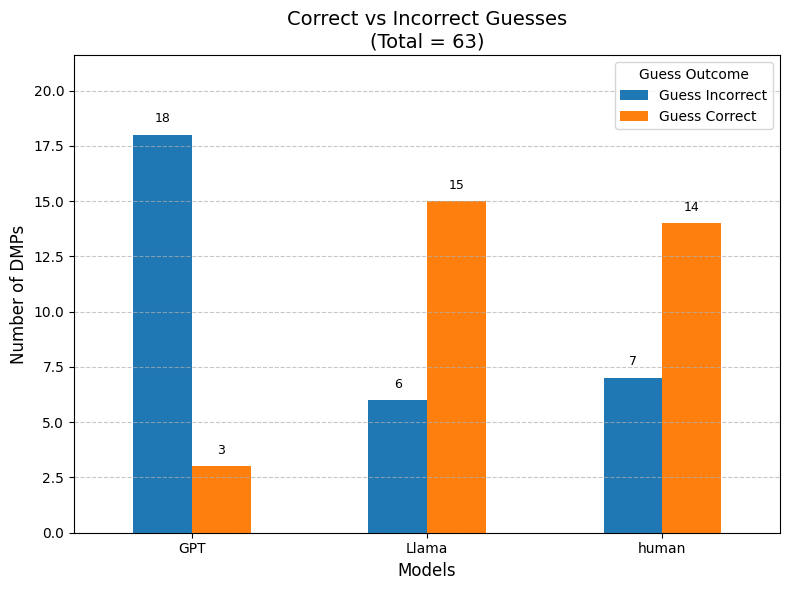

💾 Saved grouped bar chart to: ./plots\grouped_bar_accuracy_by_source.png


In [9]:
import os
import matplotlib.pyplot as plt

# --- Output directory (same as before) ---
OUT_DIR = "./plots"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Prepare grouped data ---
# Count correct/incorrect for each source (Human, GPT, Llama)
acc_counts = (
    df.groupby("source")["is_correct"]
      .value_counts()
      .unstack(fill_value=0)
      .rename(columns={1: "Guess Correct", 0: "Guess Incorrect"})
      .sort_index()
)

print("\n📊 Accuracy counts by source (Human, GPT, Llama):")
print(acc_counts)

# --- Totals ---
total_responses = int(acc_counts.to_numpy().sum())

# --- Plot grouped bar chart ---
fig, ax = plt.subplots(figsize=(8, 6))
acc_counts.plot(kind="bar", ax=ax)  # default colors

ax.set_ylabel("Number of DMPs", fontsize=12)
ax.set_xlabel("Models", fontsize=12)   # <-- caption added
ax.set_title(f"Correct vs Incorrect Guesses\n(Total = {total_responses})", fontsize=14)
ax.set_xticklabels(acc_counts.index, rotation=0)
ax.legend(title="Guess Outcome")

# Give extra headroom for labels
max_val = acc_counts.values.max() if total_responses > 0 else 1
ymax = max_val * 1.2
ax.set_ylim(0, ymax)

# Add count labels ONLY (NO percentages)
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + (ymax * 0.02),
                f"{int(height)}",
                ha="center", va="bottom", fontsize=9
            )

ax.grid(axis="y", linestyle="--", alpha=0.7)
fig.tight_layout()

# --- Save, show, close ---
save_path = os.path.join(OUT_DIR, "grouped_bar_accuracy_by_source.png")
fig.savefig(save_path, dpi=300)
plt.show()
plt.close(fig)

print("💾 Saved grouped bar chart to:", save_path)


In [10]:

# ---------- Expand the JSON column ----------
rows = []
for _, r in df.iterrows():
    raw = r.get("evaluations", "")
    items = []
    if isinstance(raw, str) and raw.strip():
        try:
            items = json.loads(raw)
        except json.JSONDecodeError:
            # Clean up small formatting issues like trailing ellipses
            cleaned = re.sub(r"\.\.\.$", "", raw).strip()
            try:
                items = json.loads(cleaned)
            except Exception:
                items = []
    for it in items:
        rows.append({
            "id": r.get("id"),
            "participantId": r.get("participantId"),
            "dmpName": r.get("dmpName"),
            "overallAuthorshipGuess": r.get("overallAuthorshipGuess"),
            "overallSatisfaction": r.get("overallSatisfaction"),
            "elementTitle": it.get("elementTitle"),
            "selectedErrors": it.get("selectedErrors", []),
            "satisfactionScore": it.get("satisfactionScore"),
            "additionalComments": it.get("additionalComments", ""),
        })

# ---------- Create Expanded DataFrame ----------
expanded = pd.DataFrame(rows)

# ---------- Optional: Save to CSV ----------
expanded.to_csv(os.path.join(DATA_DIR, "expanded_evaluations.csv"), index=False)
expanded


,id,participantId,dmpName,overallAuthorshipGuess,overallSatisfaction,elementTitle,selectedErrors,satisfactionScore,additionalComments
0,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,Human,4,Element 1: Data Type,[None--No errors seen],Very Satisfied,
1,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,Human,4,"Element 2: Related Tools, Software and/or Code:",[None--No errors seen],Very Satisfied,
2,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,Human,4,Element 3: Standards:,[None--No errors seen],Very Satisfied,
3,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,Human,4,"Element 4: Data Preservation, Access, and Asso...",[None--No errors seen],Very Satisfied,
4,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,Human,4,"Element 5: Access, Distribution, or Reuse Cons...",[None--No errors seen],Very Satisfied,
...,...,...,...,...,...,...,...,...,...
373,cmgi1yfsa000b71010hb6sr9q,1021,human_4,Human,3,"Element 2: Related Tools, Software and/or Code:",[None--No errors seen],Satisfied,
374,cmgi1yfsa000b71010hb6sr9q,1021,human_4,Human,3,Element 3: Standards:,[Completeness--Missing something that is requi...,Very Dissatisfied,There is no mention of standards at all. cm/mm...
375,cmgi1yfsa000b71010hb6sr9q,1021,human_4,Human,3,"Element 4: Data Preservation, Access, and Asso...","[Clarity--Uses vague language, such as saying ...",Neither dissatisfied or satisfied,It really just relies on the original dataset ...
376,cmgi1yfsa000b71010hb6sr9q,1021,human_4,Human,3,"Element 5: Access, Distribution, or Reuse Cons...",[None--No errors seen],Satisfied,It still just relies on the protocols of the r...


In [11]:
# ============ Expand the JSON column ============
rows = []
for _, r in df.iterrows():
    raw = r.get("evaluations", "")
    items = []

    # Attempt to parse the JSON string
    if isinstance(raw, str) and raw.strip():
        try:
            items = json.loads(raw)
        except json.JSONDecodeError:
            # Handle trailing issues or malformed JSON
            cleaned = re.sub(r"\.\.\.$", "", raw).strip()
            try:
                items = json.loads(cleaned)
            except Exception:
                items = []

    # Extract fields from each item in the JSON list
    for it in items:
        rows.append({
            "id": r.get("id"),
            "participantId": r.get("participantId"),
            "dmpName": r.get("dmpName"),
            "overallAuthorshipGuess": r.get("overallAuthorshipGuess"),
            "overallSatisfaction": r.get("overallSatisfaction"),
            "elementTitle": it.get("elementTitle", None),
            "selectedErrors": it.get("selectedErrors", []),
            "satisfactionScore": it.get("satisfactionScore", None),
            "additionalComments": it.get("additionalComments", ""),
        })

# ============ Convert to DataFrame ============
expanded = pd.DataFrame(rows)

# ============ Map satisfaction to ordinal ============
sat_map = {
    "Very Dissatisfied": 1,
    "Dissatisfied": 2,
    "Neither dissatisfied or satisfied": 3,
    "Satisfied": 4,
    "Very Satisfied": 5,
}
expanded["satisfactionOrdinal"] = expanded["satisfactionScore"].map(sat_map)

expanded

,id,participantId,dmpName,overallAuthorshipGuess,overallSatisfaction,elementTitle,selectedErrors,satisfactionScore,additionalComments,satisfactionOrdinal
0,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,Human,4,Element 1: Data Type,[None--No errors seen],Very Satisfied,,5.0
1,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,Human,4,"Element 2: Related Tools, Software and/or Code:",[None--No errors seen],Very Satisfied,,5.0
2,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,Human,4,Element 3: Standards:,[None--No errors seen],Very Satisfied,,5.0
3,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,Human,4,"Element 4: Data Preservation, Access, and Asso...",[None--No errors seen],Very Satisfied,,5.0
4,cmf5ty7vf000f71010cu38kpq,1010,GPT_2,Human,4,"Element 5: Access, Distribution, or Reuse Cons...",[None--No errors seen],Very Satisfied,,5.0
...,...,...,...,...,...,...,...,...,...,...
373,cmgi1yfsa000b71010hb6sr9q,1021,human_4,Human,3,"Element 2: Related Tools, Software and/or Code:",[None--No errors seen],Satisfied,,4.0
374,cmgi1yfsa000b71010hb6sr9q,1021,human_4,Human,3,Element 3: Standards:,[Completeness--Missing something that is requi...,Very Dissatisfied,There is no mention of standards at all. cm/mm...,1.0
375,cmgi1yfsa000b71010hb6sr9q,1021,human_4,Human,3,"Element 4: Data Preservation, Access, and Asso...","[Clarity--Uses vague language, such as saying ...",Neither dissatisfied or satisfied,It really just relies on the original dataset ...,3.0
376,cmgi1yfsa000b71010hb6sr9q,1021,human_4,Human,3,"Element 5: Access, Distribution, or Reuse Cons...",[None--No errors seen],Satisfied,It still just relies on the protocols of the r...,4.0


In [12]:
import os
import re
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Output directory ===
OUT_DIR = "./plots"
os.makedirs(OUT_DIR, exist_ok=True)

# === Helper functions ===
def make_element_short(s):
    if pd.isna(s): return None
    m = re.search(r'(?i)\b(elem(?:ent|n|nt)?)\s*(\d+)', str(s))
    return f"Element {m.group(2)}" if m else None

def element_order_key(x):
    if not isinstance(x, str): return 1_000_000
    m = re.search(r'Element\s+(\d+)', x)
    return int(m.group(1)) if m else 1_000_000

def parse_errors(x):
    if isinstance(x, list): return x
    if pd.isna(x) or str(x).strip() == "": return []
    try:
        v = json.loads(str(x))
        return v if isinstance(v, list) else [str(v)]
    except:
        try:
            v = ast.literal_eval(str(x))
            return v if isinstance(v, list) else [str(v)]
        except:
            return [str(x)]

def clean_error_list(lst):
    keep = []
    for e in lst:
        s = str(e).strip()
        if re.fullmatch(r'(?i)none(\s*--.*)?', s): continue
        if re.fullmatch(r'(?i)no\s*errors?\s*seen', s): continue
        keep.append(s)
    return keep

def simplify_error_label(lbl):
    return str(lbl).split("--", 1)[0].strip()

def extract_model(dmp):
    if pd.isna(dmp): return "Unknown"
    s = str(dmp).split("_")[0].strip().lower()
    if s == "gpt": return "GPT"
    elif s == "llama": return "Llama"
    elif s == "human": return "Human"
    return "Unknown"

def contrast_color(val_pct, cmap, norm):
    r, g, b, _ = cmap(norm(val_pct))
    lum = 0.299*r + 0.587*g + 0.114*b
    return "black" if lum > 0.6 else "white"

# === Preprocessing (assume `expanded` is already loaded) ===
expanded["elementShort"] = expanded["elementTitle"].apply(make_element_short)
expanded["parsedErrors"] = expanded["selectedErrors"].apply(parse_errors).apply(clean_error_list)
expanded["model"] = expanded["dmpName"].apply(extract_model)

# === Group-by-model analysis ===
model_types = ["GPT", "Llama", "Human"]

for model in model_types:
    print(f"\n=== MODEL: {model} ===")
    df_model = expanded[expanded["model"] == model].copy()

    # --- Explode errors ---
    err_exp = (
        df_model
        .explode("parsedErrors")
        .assign(errorSimple=lambda d: d["parsedErrors"].fillna("").astype(str).map(simplify_error_label))
    )
    err_exp = err_exp[
        err_exp["errorSimple"].str.strip().ne("") &
        err_exp["errorSimple"].str.lower().ne("none")
    ]

    # --- Error counts ---
    error_counts = (
        err_exp
        .groupby(["elementShort", "errorSimple"], dropna=False)
        .size()
        .reset_index(name="count")
    )
    error_counts["__ord"] = error_counts["elementShort"].map(element_order_key)
    error_counts = error_counts.sort_values(["__ord", "count"], ascending=[True, False]).drop(columns="__ord")
    error_counts.to_csv(os.path.join(OUT_DIR, f"error_counts_{model}.csv"), index=False)

    # --- Error matrix ---
    error_matrix = (
        error_counts
        .pivot(index="errorSimple", columns="elementShort", values="count")
        .fillna(0)
        .astype(int)
    )
    error_matrix = error_matrix[sorted(error_matrix.columns, key=element_order_key)]
    error_matrix = error_matrix.sort_index()
    error_matrix.to_csv(os.path.join(OUT_DIR, f"error_matrix_{model}.csv"))

    # --- Satisfaction stats ---
    sat_stats = (
        df_model
        .dropna(subset=["elementShort", "satisfactionOrdinal"])
        .groupby("elementShort", as_index=False)["satisfactionOrdinal"]
        .agg(mean="mean", std="std", n="count", median="median")
    )
    sat_stats["__ord"] = sat_stats["elementShort"].map(element_order_key)
    sat_stats = sat_stats.sort_values("__ord").drop(columns="__ord").reset_index(drop=True)
    sat_stats.to_csv(os.path.join(OUT_DIR, f"satisfaction_stats_{model}.csv"), index=False)

    # --- Summary with top 3 errors ---
    top_errors = (
        error_counts
        .groupby("elementShort", as_index=False)
        .apply(lambda g: ", ".join(g.sort_values("count", ascending=False)
                                     .head(3)["errorSimple"].tolist()))
        .reset_index(drop=True)
        .rename(columns={0: "topErrors"})
    )
    summary = sat_stats.merge(top_errors, on="elementShort", how="left")
    summary.to_csv(os.path.join(OUT_DIR, f"element_summary_{model}.csv"), index=False)

    # === HEATMAP ===
    col_totals = error_matrix.sum(axis=0).replace(0, np.nan)
    pct_matrix = (error_matrix.div(col_totals, axis=1) * 100).fillna(0)

    # Filter non-zero errors only
    mask_nonzero = error_matrix.sum(axis=1) > 0
    error_matrix = error_matrix.loc[mask_nonzero]
    pct_matrix = pct_matrix.loc[mask_nonzero]

    # --- Plot ---
    plt.figure(figsize=(12, max(6, 0.3 * len(error_matrix.index))))
    im = plt.imshow(pct_matrix.values, aspect="auto", cmap='viridis')
    plt.colorbar(label="Percent of Errors (%)")
    plt.xticks(range(pct_matrix.shape[1]), pct_matrix.columns, rotation=0)
    plt.yticks(range(pct_matrix.shape[0]), error_matrix.index)
    plt.title(f"Error Distribution per Element – {model}")

    cmap = im.get_cmap()
    norm = im.norm
    for r in range(pct_matrix.shape[0]):
        for c in range(pct_matrix.shape[1]):
            cnt = int(error_matrix.iat[r, c])
            if cnt > 0:
                pct = float(pct_matrix.iat[r, c])
                txt = f"{pct:.0f}%\n({cnt})"
                plt.text(c, r, txt, ha="center", va="center", fontsize=8, color=contrast_color(pct, cmap, norm))

    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"error_percent_heatmap_{model}.png"), dpi=150)
    plt.close()

# === Comparison table like your Word screenshot ===

element_labels = {
    "Element 1": "Types and Amount of Scientific Data; Data to be Preserved and Shared; Metadata and Documentation",
    "Element 2": "Tools, Software, and Code",
    "Element 3": "Standards",
    "Element 4": "Repository, Findability, and Availability Timeline",
    "Element 5": "Access, Distribution, Reuse, Controlled Access, Privacy, and Confidentiality",
    "Element 6": "Oversight of DMP"
}

# Load satisfaction stats and merge
all_stats = []
for model in model_types:
    path = os.path.join(OUT_DIR, f"satisfaction_stats_{model}.csv")
    df = pd.read_csv(path)
    df["model"] = model
    all_stats.append(df)

df_all = pd.concat(all_stats, ignore_index=True)
df_all["mean_std"] = df_all.apply(lambda r: f"{r['mean']:.1f}±{r['std']:.2f}", axis=1)

# Pivot to wide
table = df_all.pivot(index="elementShort", columns="model", values="mean_std").reset_index()
table.insert(1, "elementField", table["elementShort"].map(element_labels))
table = table.sort_values("elementShort", key=lambda col: col.map(element_order_key))

# Rename for clarity
table.columns.name = None
table = table.rename(columns={
    "elementShort": "elementNumber",
    "Llama": "Llama 3.3",
    "GPT": "GPT 4.1",
    "Human": "Human"
})

# Save
final_path = os.path.join(OUT_DIR, "satisfaction_comparison_table.csv")
table.to_csv(final_path, index=False)
print("\n✅ Saved satisfaction comparison table to:", final_path)



=== MODEL: GPT ===

=== MODEL: Llama ===


C:\Users\User\AppData\Local\Temp\ipykernel_59784\1111496166.py:122: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ", ".join(g.sort_values("count", ascending=False)
C:\Users\User\AppData\Local\Temp\ipykernel_59784\1111496166.py:122: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ", ".join(g.sort_values("count", ascending=False)



=== MODEL: Human ===


C:\Users\User\AppData\Local\Temp\ipykernel_59784\1111496166.py:122: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ", ".join(g.sort_values("count", ascending=False)



✅ Saved satisfaction comparison table to: ./plots\satisfaction_comparison_table.csv


In [14]:
# ============================================================
# Survey Analysis (Publication-Ready Enhanced View)
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# --- File paths ---
DATA_DIR = "./data"
BG_FILE = os.path.join(DATA_DIR, "data-1760978508376.csv")
EVAL_FILE = os.path.join(DATA_DIR, "data-1760978361180.csv")
OUT_DIR = os.path.join(DATA_DIR, "filtered_analysis_pub")
os.makedirs(OUT_DIR, exist_ok=True)

# --- Load data ---
background_df = pd.read_csv(BG_FILE)
eval_df = pd.read_csv(EVAL_FILE)

# --- Drop null participants and extract valid participant IDs ---
background_df = background_df.dropna(subset=["participantId"])
eval_ids = eval_df["participantId"].dropna().unique()

# --- Filter background based on evaluation participants ---
df = background_df[background_df["participantId"].isin(eval_ids)].copy()
print(f"✅ Filtered participants: {df['participantId'].nunique()}")



✅ Filtered participants: 21


In [15]:
import re
import numpy as np
import pandas as pd

# ============================================================
# Controlled Mapping Dictionary
# ============================================================

field_category_map = {
    # 1️⃣ Library & Information Science
    "library science": "Library & Information Science",
    "library and information science": "Library & Information Science",
    "information science": "Library & Information Science",
    "information studies": "Library & Information Science",

    # 2️⃣ Biological & Life Sciences
    "biology": "Biological & Life Sciences",
    "microbiology": "Biological & Life Sciences",
    "biochemistry": "Biological & Life Sciences",
    "marine science": "Biological & Life Sciences",
    "neuroscience": "Biological & Life Sciences",
    "life science": "Biological & Life Sciences",

    # 3️⃣ STEM Fields
    "stem": "STEM Fields",
    "engineering": "STEM Fields",
    "physics": "STEM Fields",
    "mathematics": "STEM Fields",
    "informatics": "STEM Fields",
    "data science": "STEM Fields",
    "computer science": "STEM Fields",

    # 4️⃣ Social Sciences
    "social science": "Social Sciences",
    "social sciences": "Social Sciences",
    "psychology": "Social Sciences",
    "sociology": "Social Sciences",
    "anthropology": "Social Sciences",
    "education": "Social Sciences",
    "economics": "Social Sciences",
    "political science": "Social Sciences",
}


# ============================================================
# Categorization Function (supports multiple labels per cell)
# ============================================================

def categorize_field(value):
    """
    Map each free-text 'field' entry into standardized categories.
    Supports multiple fields separated by commas, slashes, etc.
    Example:
        "Library Science, Biology" → "Library & Information Science, Biological & Life Sciences"
    """
    if pd.isna(value):
        return np.nan

    text = str(value).strip().lower()
    text = re.sub(r"\s+", " ", text)  # normalize spaces
    # split on commas, slashes, semicolons, pipes
    parts = re.split(r",|;|/|\|", text)

    mapped = set()
    for part in parts:
        p = part.strip()
        if not p:
            continue
        matched = False
        for keyword, category in field_category_map.items():
            if keyword in p:
                mapped.add(category)
                matched = True
                break
        if not matched:
            mapped.add("Other")

    return ", ".join(sorted(mapped)) if mapped else np.nan


# ============================================================
# Apply to DataFrame and Expand Multi-Fields (Optional)
# ============================================================

df["fieldCategory"] = df["field"].apply(categorize_field)

# (Optional) create a long-form version — each category as a separate row
expanded_rows = []
for _, row in df.iterrows():
    field_value = row.get("fieldCategory", "")
    if pd.isna(field_value):
        continue
    for cat in [c.strip() for c in field_value.split(",") if c.strip()]:
        new_row = row.copy()
        new_row["fieldCategory_expanded"] = cat
        expanded_rows.append(new_row)

df_expanded = pd.DataFrame(expanded_rows)

# ============================================================
# Preview results
# ============================================================
print("✅ Sample categorized 'fieldCategory' values:")
print(df[["field", "fieldCategory"]].head(10))

print("\n✅ Expanded (multi-category) format preview:")
print(df_expanded[["field", "fieldCategory_expanded"]].head(10))


✅ Sample categorized 'fieldCategory' values:
                              field                  fieldCategory
0   library and information science  Library & Information Science
1                   Library Science  Library & Information Science
2                  Library science   Library & Information Science
4                           Biology     Biological & Life Sciences
5                   Library science  Library & Information Science
6                   Library Science  Library & Information Science
7                              STEM                    STEM Fields
9                   library science  Library & Information Science
10                          Biology     Biological & Life Sciences
11                     Neuroscience     Biological & Life Sciences

✅ Expanded (multi-category) format preview:
                              field         fieldCategory_expanded
0   library and information science  Library & Information Science
1                   Library Science  Li

In [16]:
summary = df_expanded["fieldCategory_expanded"].value_counts().reset_index()
summary.columns = ["Field Category", "N"]
summary["Percent"] = (summary["N"] / summary["N"].sum() * 100).round(1)
print(summary)


                  Field Category   N  Percent
0  Library & Information Science  12     54.5
1     Biological & Life Sciences   7     31.8
2                Social Sciences   2      9.1
3                    STEM Fields   1      4.5


In [18]:
import pandas as pd
import numpy as np
import re

# ============================================================
# Controlled Categories (from your survey)
# ============================================================

CATEGORIES = {
    "Researcher": "Researcher (e.g., student, faculty, post-doctoral)",
    "Admin": "Research administrator / Program officer",
    "DataMgr": "Data manager / Data steward",
    "Librarian": "Librarian / Data librarian / Research support staff",
    "Other": "Other",
}

# ============================================================
# Keyword mapping for automatic categorization
# ============================================================

ROLE_KEYWORDS = {
    "researcher": CATEGORIES["Researcher"],
    "student": CATEGORIES["Researcher"],
    "faculty": CATEGORIES["Researcher"],
    "post": CATEGORIES["Researcher"],

    "administrator": CATEGORIES["Admin"],
    "program officer": CATEGORIES["Admin"],
    "program manager": CATEGORIES["Admin"],

    "data manager": CATEGORIES["DataMgr"],
    "data steward": CATEGORIES["DataMgr"],

    "librarian": CATEGORIES["Librarian"],
    "research support": CATEGORIES["Librarian"],

    "other": CATEGORIES["Other"],
}

# ============================================================
# Helper: Parse list-like text into a Python list
# ============================================================

def parse_list(value):
    """Handle values like '{"A","B"}' or "['A','B']" or 'A,B'."""
    if pd.isna(value):
        return []
    text = str(value).strip()
    text = text.strip("{}[]")  # remove braces/brackets
    text = text.replace('"', '').replace("'", "")
    parts = re.split(r",|;", text)
    return [p.strip() for p in parts if p.strip()]

# ============================================================
# Map each role string to a controlled category
# ============================================================

def map_role_to_category(role_str):
    if not isinstance(role_str, str):
        return CATEGORIES["Other"]
    r_lower = role_str.lower()
    for keyword, category in ROLE_KEYWORDS.items():
        if keyword in r_lower:
            return category
    return CATEGORIES["Other"]

# ============================================================
# Normalize and Expand Roles
# ============================================================

def normalize_roles_column(df, role_column="roles"):
    """Normalize, categorize, and expand multiple roles."""
    expanded_rows = []
    for _, row in df.iterrows():
        roles_raw = parse_list(row[role_column])
        for r in roles_raw:
            category = map_role_to_category(r)
            new_row = row.copy()
            new_row["roleCategory_expanded"] = category
            expanded_rows.append(new_row)
    return pd.DataFrame(expanded_rows)






In [19]:
import pandas as pd

# ============================================================
duration_order = [
    "Less than 1 year",
    "1–3 years",
    "4–6 years",
    "7–10 years",
    "More than 10 years"
]

# Convert to ordered categorical type
df["roleDuration_clean"] = pd.Categorical(df["roleDuration"], categories=duration_order, ordered=True)

# ============================================================
# Create summary (N and %)
# ============================================================
summary = (
    df["roleDuration_clean"]
    .value_counts(dropna=False)
    .reindex(duration_order)
    .reset_index()
)
summary.columns = ["Experience Duration", "N"]
summary["N"] = summary["N"].fillna(0).astype(int)
summary["Percent"] = (summary["N"] / summary["N"].sum() * 100).round(1)

# ============================================================
# Display
# ============================================================
print("\n📊 Role Duration Summary:")
print(summary.to_string(index=False))




📊 Role Duration Summary:
Experience Duration  N  Percent
   Less than 1 year  2      9.5
          1–3 years  3     14.3
          4–6 years  9     42.9
         7–10 years  3     14.3
 More than 10 years  4     19.0


In [20]:
df["dmpCount"] = (
    df["dmpCount"]
    .astype(str)
    .str.replace("â€“", "–", regex=False)  # fix corrupted en-dash
    .str.strip()
)

# Define standard categories in correct order
dmp_order = [
    "1",
    "2–3",
    "4–5",
    "More than 5"
]

# Normalize potential variants
df["dmpCount_clean"] = df["dmpCount"].replace({
    "2-3": "2–3",
    "4-5": "4–5",
    "More than five": "More than 5",
    "More than five DMPs": "More than 5",
})

# Convert to ordered categorical type
df["dmpCount_clean"] = pd.Categorical(df["dmpCount_clean"], categories=dmp_order, ordered=True)

# ============================================================
# Create summary table
# ============================================================

summary = (
    df["dmpCount_clean"]
    .value_counts(dropna=False)
    .reindex(dmp_order)
    .reset_index()
)
summary.columns = ["Number of DMPs Authored or Co-authored", "N"]
summary["N"] = summary["N"].fillna(0).astype(int)
summary["Percent"] = (summary["N"] / summary["N"].sum() * 100).round(1)

# ============================================================
# Display results
# ============================================================
print("\n📊 DMP Count Summary:")
print(summary.to_string(index=False))



📊 DMP Count Summary:
Number of DMPs Authored or Co-authored  N  Percent
                                     1  3     25.0
                                   2–3  4     33.3
                                   4–5  2     16.7
                           More than 5  3     25.0


In [21]:
# ============================================================
# Define ordered categories (as in your survey)
# ============================================================
freq_order = [
    "Weekly or more often",
    "About once a month",
    "Every few months",
    "Once or twice a year"
]

# Normalize spacing/capitalization just in case
df["dmpReviewFrequency_clean"] = df["dmpReviewFrequency"].astype(str).str.strip()

# Convert to ordered categorical type
df["dmpReviewFrequency_clean"] = pd.Categorical(
    df["dmpReviewFrequency_clean"],
    categories=freq_order,
    ordered=True
)

# ============================================================
# Create summary table (N and %)
# ============================================================
summary = (
    df["dmpReviewFrequency_clean"]
    .value_counts(dropna=False)
    .reindex(freq_order)
    .reset_index()
)
summary.columns = ["DMP Review Frequency", "N"]
summary["N"] = summary["N"].fillna(0).astype(int)
summary["Percent"] = (summary["N"] / summary["N"].sum() * 100).round(1)

# ============================================================
# Display results
# ============================================================
print("\n📊 DMP Review Frequency Summary:")
print(summary.to_string(index=False))


📊 DMP Review Frequency Summary:
DMP Review Frequency  N  Percent
Weekly or more often  2      9.5
  About once a month 10     47.6
    Every few months  6     28.6
Once or twice a year  3     14.3


In [22]:
# ============================================================
familiarity_order = [
    "Slightly familiar",
    "Somewhat familiar",
    "Moderately familiar",
    "Extremely familiar"
]

# Normalize capitalization and spacing
df["dmsFamiliarity_clean"] = df["dmsFamiliarity"].astype(str).str.strip()

# Convert to ordered categorical type
df["dmsFamiliarity_clean"] = pd.Categorical(
    df["dmsFamiliarity_clean"],
    categories=familiarity_order,
    ordered=True
)

# ============================================================
# Create summary (N and %)
# ============================================================
summary = (
    df["dmsFamiliarity_clean"]
    .value_counts(dropna=False)
    .reindex(familiarity_order)
    .reset_index()
)
summary.columns = ["Familiarity with Data Management Systems (DMS)", "N"]
summary["N"] = summary["N"].fillna(0).astype(int)
summary["Percent"] = (summary["N"] / summary["N"].sum() * 100).round(1)

# ============================================================
# Display results
# ============================================================
print("\n📊 DMS Familiarity Summary:")
print(summary.to_string(index=False))



📊 DMS Familiarity Summary:
Familiarity with Data Management Systems (DMS)  N  Percent
                             Slightly familiar  1      4.8
                             Somewhat familiar  4     19.0
                           Moderately familiar  7     33.3
                            Extremely familiar  9     42.9


In [23]:
# ============================================================
ai_usage_order = [
    "Never",
    "Almost never",
    "Occasionally / Sometimes",
    "Often"
]

# ============================================================
# Clean and normalize aiUsage column
# ============================================================
df["aiUsage_clean"] = (
    df["aiUsage"]
    .astype(str)
    .str.strip()
    .replace({
        "Occasionally/Sometimes": "Occasionally / Sometimes",
        "Occasionally sometimes": "Occasionally / Sometimes",
        "occasionally / sometimes": "Occasionally / Sometimes",
        "almost never": "Almost never",
        "never": "Never",
        "often": "Often",
    })
)

# Convert to ordered categorical type
df["aiUsage_clean"] = pd.Categorical(df["aiUsage_clean"], categories=ai_usage_order, ordered=True)

# ============================================================
# Create summary (N and %)
# ============================================================
summary = (
    df["aiUsage_clean"]
    .value_counts(dropna=False)
    .reindex(ai_usage_order)
    .reset_index()
)
summary.columns = ["AI Usage Frequency", "N"]
summary["N"] = summary["N"].fillna(0).astype(int)
summary["Percent"] = (summary["N"] / summary["N"].sum() * 100).round(1)

# ============================================================
# Display results
# ============================================================
print("\n📊 AI Usage Summary:")
print(summary.to_string(index=False))



📊 AI Usage Summary:
      AI Usage Frequency  N  Percent
                   Never 12     57.1
            Almost never  2      9.5
Occasionally / Sometimes  6     28.6
                   Often  1      4.8


In [24]:
# ============================================================
comfort_order = [
    "Not at all comfortable",
    "Slightly comfortable",
    "Somewhat comfortable",
    "Moderately comfortable"
]

# ============================================================
# Clean and normalize aiComfort column
# ============================================================
df["aiComfort_clean"] = (
    df["aiComfort"]
    .astype(str)
    .str.strip()
    .replace({
        "not at all comfortable": "Not at all comfortable",
        "slightly comfortable": "Slightly comfortable",
        "somewhat comfortable": "Somewhat comfortable",
        "moderately comfortable": "Moderately comfortable",
    })
)

# Convert to ordered categorical type
df["aiComfort_clean"] = pd.Categorical(
    df["aiComfort_clean"],
    categories=comfort_order,
    ordered=True
)

# ============================================================
# Create summary (N and %)
# ============================================================
summary = (
    df["aiComfort_clean"]
    .value_counts(dropna=False)
    .reindex(comfort_order)
    .reset_index()
)
summary.columns = ["Comfort Level with AI Tools", "N"]
summary["N"] = summary["N"].fillna(0).astype(int)
summary["Percent"] = (summary["N"] / summary["N"].sum() * 100).round(1)

# ============================================================
# Display results
# ============================================================
print("\n📊 AI Comfort Summary:")
print(summary.to_string(index=False))



📊 AI Comfort Summary:
Comfort Level with AI Tools  N  Percent
     Not at all comfortable  4     19.0
       Slightly comfortable 10     47.6
       Somewhat comfortable  5     23.8
     Moderately comfortable  2      9.5


In [25]:
# ============================================================
attitude_order = [
    "Very against it",
    "Somewhat against it",
    "Neutral toward it",
    "Somewhat in favor of it",
    "Very in favor of it"
]

# ============================================================
# Clean and normalize aiAttitude column
# ============================================================
df["aiAttitude_clean"] = (
    df["aiAttitude"]
    .astype(str)
    .str.strip()
    .replace({
        "very against it": "Very against it",
        "somewhat against it": "Somewhat against it",
        "neutral": "Neutral toward it",
        "neutral toward ai": "Neutral toward it",
        "neutral toward it": "Neutral toward it",
        "somewhat in favor of it": "Somewhat in favor of it",
        "very in favor of it": "Very in favor of it"
    })
)

# Convert to ordered categorical type
df["aiAttitude_clean"] = pd.Categorical(
    df["aiAttitude_clean"],
    categories=attitude_order,
    ordered=True
)

# ============================================================
# Create summary (N and %)
# ============================================================
summary = (
    df["aiAttitude_clean"]
    .value_counts(dropna=False)
    .reindex(attitude_order)
    .reset_index()
)
summary.columns = ["Attitude Toward AI", "N"]
summary["N"] = summary["N"].fillna(0).astype(int)
summary["Percent"] = (summary["N"] / summary["N"].sum() * 100).round(1)

# ============================================================
# Display results
# ============================================================
print("\n📊 AI Attitude Summary:")
print(summary.to_string(index=False))


📊 AI Attitude Summary:
     Attitude Toward AI  N  Percent
        Very against it  1      4.8
    Somewhat against it  6     28.6
      Neutral toward it  5     23.8
Somewhat in favor of it  8     38.1
    Very in favor of it  1      4.8



📊 Sentiment Summary:
count    11.000000
mean      0.195426
std       0.178935
min      -0.071429
25%       0.029167
50%       0.200000
75%       0.338889
max       0.450000
Name: sentiment, dtype: float64
✅ Saved: ./plots\sentiment_summary.csv


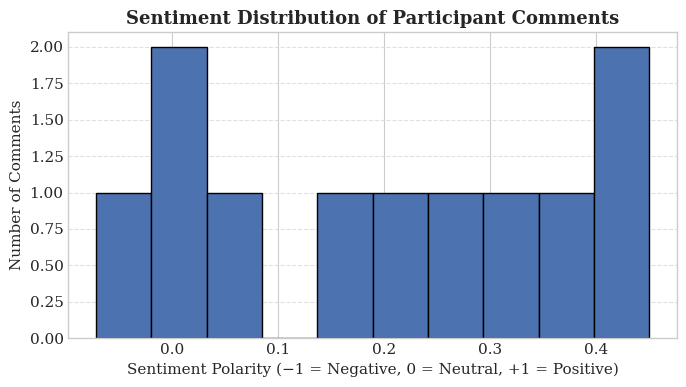


🧾 Sentiment Category Counts:
sentiment_category
Positive    7
Neutral     4
Name: count, dtype: int64


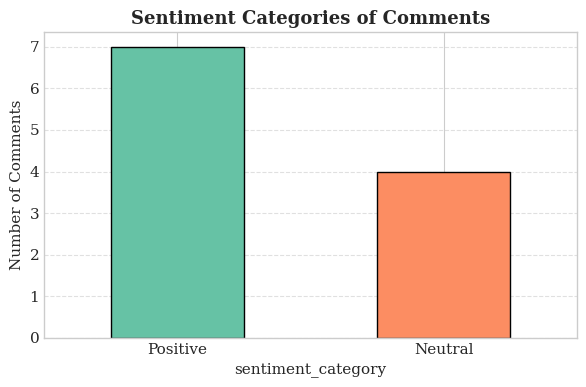

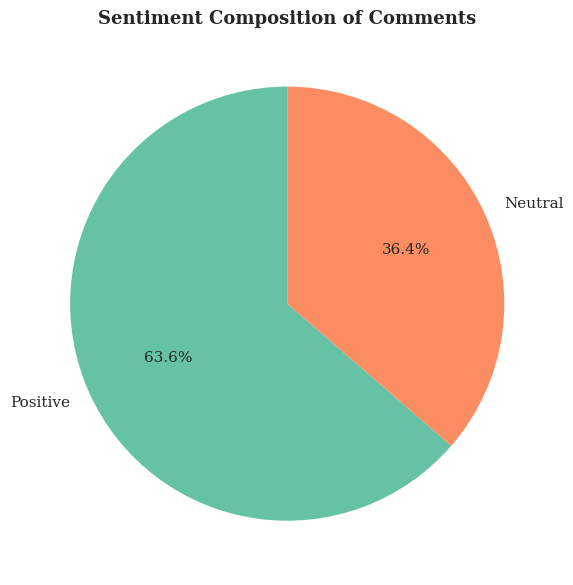

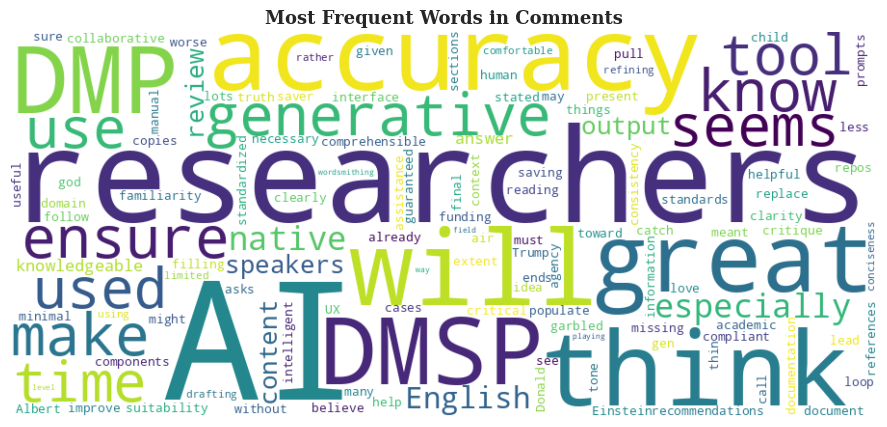


💬 Example of most positive comment:
I'm more comfortable with using generative AI for DMP review rather than drafting DMPs. 
(Sentiment = 0.450)

💬 Example of most negative comment:
My use of AI has been limited to refining answers for conciseness and wordsmithing. 
(Sentiment = -0.071)
✅ Saved: ./plots\sentiment_comments.csv

✅ Sentiment analysis complete. Results saved to: ./plots


In [73]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud

# ==============================
# Set up output directory
# ==============================
OUT_DIR = "./plots"
os.makedirs(OUT_DIR, exist_ok=True)

# ==============================
# Safe CSV Save Function
# ==============================
def safe_save_csv(df, filename):
    try:
        df.to_csv(filename, index=False)
        print(f"✅ Saved: {filename}")
    except PermissionError:
        alt = filename.replace(".csv", "_new.csv")
        print(f"⚠️ File locked. Saving as: {alt}")
        df.to_csv(alt, index=False)

# ==============================
# Extract Comments & Compute Sentiment
# ==============================
comments = df["additionalComments"].dropna().astype(str).tolist()
sentiments = [TextBlob(comment).sentiment.polarity for comment in comments]

df_sentiment = pd.DataFrame({
    "comment": comments,
    "sentiment": sentiments
})

# Optional: Bring in group info if exists
if "dmpName" in df.columns:
    df_sentiment["dmpName"] = df.loc[df["additionalComments"].dropna().index, "dmpName"].values
if "modelType" in df.columns:
    df_sentiment["modelType"] = df.loc[df["additionalComments"].dropna().index, "modelType"].values

# ==============================
# Summary Statistics Table
# ==============================
print("\n📊 Sentiment Summary:")
summary_stats = df_sentiment["sentiment"].describe()
print(summary_stats)

summary_path = os.path.join(OUT_DIR, "sentiment_summary.csv")
safe_save_csv(summary_stats.to_frame(), summary_path)

# ==============================
# Histogram: Full Sentiment Range
# ==============================
plt.figure(figsize=(7, 4))
plt.hist(df_sentiment["sentiment"], bins=10, color="#4C72B0", edgecolor="black")
plt.title("Sentiment Distribution of Participant Comments", fontweight="bold")
plt.xlabel("Sentiment Polarity (−1 = Negative, 0 = Neutral, +1 = Positive)")
plt.ylabel("Number of Comments")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "sentiment_distribution.png"), dpi=300)
plt.show()

# ==============================
# Categorize Sentiment
# ==============================
def categorize_sentiment(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

df_sentiment["sentiment_category"] = df_sentiment["sentiment"].apply(categorize_sentiment)

# ==============================
# Bar Chart: Positive / Neutral / Negative
# ==============================
category_counts = df_sentiment["sentiment_category"].value_counts()
print("\n🧾 Sentiment Category Counts:")
print(category_counts)

plt.figure(figsize=(6, 4))
category_counts.plot(kind="bar", color=["#66c2a5", "#fc8d62", "#8da0cb"], edgecolor="black")
plt.title("Sentiment Categories of Comments", fontweight="bold")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "sentiment_category_bar.png"), dpi=300)
plt.show()

# ==============================
# Pie Chart (Optional)
# ==============================
plt.figure(figsize=(6, 6))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%",
        startangle=90, colors=["#66c2a5", "#fc8d62", "#8da0cb"])
plt.title("Sentiment Composition of Comments", fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "sentiment_category_pie.png"), dpi=300)
plt.show()

# ==============================
# Mean Sentiment by Model (if available)
# ==============================
if "modelType" in df_sentiment.columns:
    mean_by_model = df_sentiment.groupby("modelType")["sentiment"].mean().sort_values()
    print("\n📈 Mean sentiment by model type:\n", mean_by_model)

    plt.figure(figsize=(6, 4))
    mean_by_model.plot(kind="bar", color="#66c2a5", edgecolor="black")
    plt.title("Average Sentiment by Model Type", fontweight="bold")
    plt.ylabel("Mean Sentiment Polarity")
    plt.xlabel("Model Type")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "mean_sentiment_by_model.png"), dpi=300)
    plt.show()

# ==============================
# Word Cloud
# ==============================
text = " ".join(df_sentiment["comment"])
wordcloud = WordCloud(width=900, height=400, background_color="white", colormap="viridis").generate(text)

plt.figure(figsize=(9, 4.5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Comments", fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "wordcloud_comments.png"), dpi=300)
plt.show()

# ==============================
# Show Example Extreme Comments
# ==============================
most_pos = df_sentiment.loc[df_sentiment["sentiment"].idxmax()]
most_neg = df_sentiment.loc[df_sentiment["sentiment"].idxmin()]

print("\n💬 Example of most positive comment:")
print(most_pos["comment"], f"\n(Sentiment = {most_pos['sentiment']:.3f})")

print("\n💬 Example of most negative comment:")
print(most_neg["comment"], f"\n(Sentiment = {most_neg['sentiment']:.3f})")

# ==============================
# Save Final Comment Table
# ==============================
final_path = os.path.join(OUT_DIR, "sentiment_comments.csv")
safe_save_csv(df_sentiment, final_path)

print("\n✅ Sentiment analysis complete. Results saved to:", OUT_DIR)
